# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [164]:
# import libraries here; add more as necessary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ast

import time

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.utils import resample

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/dilay/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Reading in Datasets (AZDIAS & CUSTOMERS)

**AZDIAS** Dataset

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [8]:
azdias.shape

(891221, 366)

**CUSTOMERS** Dataset

In [9]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [11]:
customers.shape

(191652, 369)

### Data Preprocessing

Preprocessing the AZDIAS Dataset

### 1. Drop features (columns) in AZDIAS not described in the Attributes Excel Sheet (attributes_info)

I have manually created a csv file ('attributes.csv') which can be used to easily identify and manipulate the attributes describred in the DIAS Attributes - Values 2017.xlsx file. This csv file, attributes.csv, which you can visualise the first 5 rows of below, is composed of 3 columns: Attribute (name of the attribute, i.e. some of the columns in AZDIAS dataset), Type ('categorical', 'ordinal', 'numeric') and Unknown_Values (values for each feature/column of the dataset that have the meaning of 'unknown'; see the 'Meaning' Column of the DIAS Attributes - Values 2017.xlsx file). 

This manually created csv file contains 335 rows (including the first row 'Attribute;Type;Value'), so there are a total of 334 features described. Thus, AZDIAS dataset (366 columns) contains 32 additional features not found in the attributes.csv description file.

In [2]:
attributes_info = pd.read_csv('attributes.csv', sep=';') 

In [13]:
attributes_info.head()

,Attribute,Type,Unknown_Values
0,AGER_TYP,categorical,"[-1,0]"
1,ALTERSKATEGORIE_FEIN,ordinal,"[-1,0.9]"
2,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
3,ALTER_HH,ordinal,[0]
4,ANREDE_KZ,categorical,"[-1,0]"


In [3]:
features_in_attributes_info = attributes_info['Attribute'].tolist()

In [15]:
features_in_attributes_info

['AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 

In [16]:
azdias_columns_not_described = list(set(azdias) - set(features_in_attributes_info))

In [17]:
# columns in AZDIAS dataset but not described in attributes_info: to drop
azdias_columns_not_described

['UMFELD_ALT',
 'ALTER_KIND2',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'AKT_DAT_KL',
 'ALTER_KIND4',
 'D19_LETZTER_KAUF_BRANCHE',
 'STRUKTURTYP',
 'D19_KONSUMTYP_MAX',
 'CJT_TYP_2',
 'VK_DHT4A',
 'CJT_KATALOGNUTZER',
 'RT_UEBERGROESSE',
 'UMFELD_JUNG',
 'LNR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'VHN',
 'EINGEFUEGT_AM',
 'GEMEINDETYP',
 'CJT_TYP_4',
 'CJT_TYP_3',
 'RT_KEIN_ANREIZ',
 'VHA',
 'CJT_TYP_1',
 'VK_ZG11',
 'KOMBIALTER',
 'VK_DISTANZ',
 'VERDICHTUNGSRAUM',
 'RT_SCHNAEPPCHEN',
 'ALTER_KIND3',
 'ALTER_KIND1']

In [18]:
azdias.drop(labels=azdias_columns_not_described, axis=1, inplace=True)

In [19]:
# check the remaining columns
azdias.columns

Index(['AGER_TYP', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT',
       ...
       'SOHO_KZ', 'TITEL_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=334)

In [20]:
# visualing the first few lines of AZDIAS dataset again
azdias.head()

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,SOHO_KZ,TITEL_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1,NaN,NaN,NaN,3,1,2
1,-1,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,0.0,1.0,2,3.0,9.0,4.0,5,2,1
2,-1,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,0.0,0.0,1,3.0,9.0,2.0,5,2,3
3,2,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1,NaN,9.0,7.0,3,2,4
4,-1,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,0.0,0.0,2,2.0,9.0,3.0,4,1,3


In [21]:
azdias.shape

(891221, 334)

>We went from 360 columns/features in azdias to 334 columns/features.

(Checking whether there are attributes described in attributes.csv, but not found in azdias):

In [22]:
list(set(features_in_attributes_info) - set(azdias))

[]

> There are NO features described in the xlsx file (and manually created attributes_info) that are not found in azdias, as expected.

### 2. Convert Missing ('X' or 'XX') and Unknown Values of the AZDIAS features/columns to NaN values

Let's create a Pandas Series holding the values referring to 'unknown' for each feature/column of the azdias dataset.
We need, as part of the data cleaning and preprocessing step, to convert these values to NaN values.

In [23]:
unknown_series = pd.Series(attributes_info['Unknown_Values'].values, index=attributes_info['Attribute'])

In [24]:
unknown_series

Attribute
AGER_TYP                  [-1,0]
ALTERSKATEGORIE_FEIN    [-1,0.9]
ALTERSKATEGORIE_GROB    [-1,0,9]
ALTER_HH                     [0]
ANREDE_KZ                 [-1,0]
                          ...   
VERS_TYP                    [-1]
WOHNDAUER_2008            [-1,0]
WOHNLAGE                  [-1,0]
W_KEIT_KIND_HH            [-1,0]
ZABEOTYP                  [-1,9]
Length: 334, dtype: object

In [25]:
for column in azdias.columns:
    if azdias[column].dtype == np.int64:
        azdias[column] = azdias[column].astype(np.float64)

In [26]:
for column in azdias.columns:
    
    isin = ast.literal_eval(unknown_series[column])
    
    azdias[column] = azdias[column].mask(azdias[column].isin(isin), other=np.nan)

In [27]:
azdias.head()

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,SOHO_KZ,TITEL_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,NaN,1.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,NaN,0.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,NaN,0.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,NaN,0.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0


In [28]:
azdias.shape

(891221, 334)

### 3. a) Identify & Drop the Missing (NaN) Values COLUMN-WISE

Below are displayed the percentage of NaN values **column-wise**. We will then choose a threshold beyond which we should drop columns. This threshold must be high enough that any column with higher percentage of NaN values can be considered unuseful to our subsequent analyses.

In [32]:
# Find the percentage of missing values NaN in each column of AZDIAS, rounded to 2 decimal places
missing_perct_column = azdias.isnull().mean(axis=0)

In [33]:
missing_perct_column

AGER_TYP                0.769554
ALTER_HH                0.348137
ALTERSKATEGORIE_FEIN    0.295041
ANZ_HAUSHALTE_AKTIV     0.104517
ANZ_HH_TITEL            0.108848
                          ...   
WOHNDAUER_2008          0.082470
WOHNLAGE                0.112316
ZABEOTYP                0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.003233
Length: 334, dtype: float64

Text(0.5, 1.0, 'Proportion of NaN Values in azdias Columns')

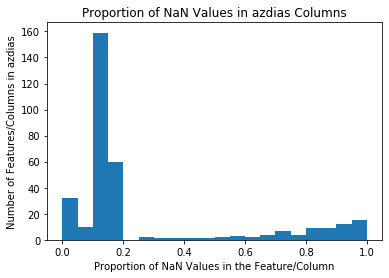

In [34]:
plt.hist(missing_perct_column, bins=20);

plt.xlabel('Proportion of NaN Values in the Feature/Column')
plt.ylabel('Number of Features/Columns in azdias')
plt.title('Proportion of NaN Values in azdias Columns')

We decide that we only want columns (in our AZDIAS dataset) that have strictly less than 20% of percentage of missing values (column-wise percentage). Below, we will narrow down our azdias dataset to satisfy this:

In [35]:
columns_to_drop = missing_perct_column[missing_perct_column > 0.2].index

columns_to_drop

Index(['AGER_TYP', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24'

In [36]:
azdias.drop(labels=columns_to_drop, axis=1, inplace=True)

In [37]:
# remaining columns in azdias
azdias.columns

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEU_2015', 'CAMEO_DEUG_2015',
       ...
       'SHOPPER_TYP', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=261)

In [38]:
# checking AZDIAS dataset shape
azdias.shape

(891221, 261)

>We went from 334 columns/features in azdias (from 2.) to 261 columns/features after 3.a)

### 3. b) Identify & Drop the Missing (NaN) Values ROW-WISE

Below are displayed the percentage of NaN values **row-wise**. We will then choose a threshold beyond which we should drop rows. This threshold must be high enough that any row with higher percentage of NaN values can be considered unuseful to our subsequent analyses.

In [39]:
# Find the percentage of missing values NaN in each row of AZDIAS, rounded to 2 decimal places
missing_perct_row = azdias.isnull().mean(axis=1)

In [40]:
missing_perct_row

0         0.862069
1         0.000000
2         0.000000
3         0.030651
4         0.000000
            ...   
891216    0.011494
891217    0.015326
891218    0.022989
891219    0.000000
891220    0.000000
Length: 891221, dtype: float64

Text(0.5, 1.0, 'Proportion of NaN Values in azdias Rows')

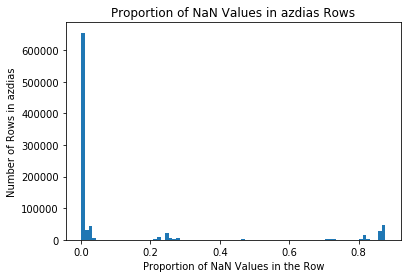

In [41]:
plt.hist(missing_perct_row, bins=80);

plt.xlabel('Proportion of NaN Values in the Row')
plt.ylabel('Number of Rows in azdias')
plt.title('Proportion of NaN Values in azdias Rows')

We decide that we only want rows (in our AZDIAS dataset) that have strictly less than 20% of percentage of missing values (row-wise percentage). Below, we will narrow down our azdias dataset to satisfy this:

In [42]:
azdias = azdias[missing_perct_row < 0.2]

In [43]:
azdias.shape

(737288, 261)

>We went from 891221 rows to 737288 rows in azdias after 3.b), with the NaN threshold set at 0.2

In [44]:
# saving modified azdias for next time I reopen the notebook (you'll also need to rerun imports cell)
# azdias.to_pickle('azdias_before_reencoding.pkl')

### 4. Re-Encoding Categorical & Mixed Features

In [45]:
# loading saved azdias 
# azdias = pd.read_pickle('azdias_before_reencoding.pkl')

Some features in the azdias dataset are categorical, some other mixed. To prepare these for feature extraction, we will need to convert these into numerical values.

**CATEGORICAL FEATURES EXPLORATION**

In [78]:
# categorical features (attention: these features are from attributes_info, some might not be in azdias)
# recall: we dropped features in azdias that were not described in attributes_info, but there might also be
# features described in attributes_info that are not found in azdias.


categorical_features_attributes = attributes_info['Attribute'].loc[attributes_info['Type'] == 'categorical']

categorical_features_attributes # 'attributes' to indicate they're from attributes_info

0              AGER_TYP
4             ANREDE_KZ
13      CAMEO_DEUG_2015
14       CAMEO_DEU_2015
16        CJT_GESAMTTYP
46        D19_KONSUMTYP
83             DSL_FLAG
86            FINANZTYP
93          GEBAEUDETYP
96      GFK_URLAUBERTYP
97     GREEN_AVANTGARDE
99        HH_DELTA_FLAG
284        KK_KUNDENTYP
286         KONSUMZELLE
287     LP_FAMILIE_FEIN
288     LP_FAMILIE_GROB
291      LP_STATUS_FEIN
292      LP_STATUS_GROB
296    NATIONALITAET_KZ
299         OST_WEST_KZ
325         SHOPPER_TYP
326             SOHO_KZ
327            TITEL_KZ
328    UNGLEICHENN_FLAG
329            VERS_TYP
333            ZABEOTYP
Name: Attribute, dtype: object

In [47]:
cat_feat_azdias = [] # categorical features (in attributes_info) that are also in azdias

for cat_feat in categorical_features_attributes:
    
    if cat_feat in azdias.columns:
        
        print(cat_feat + ', feature from attributes_info, is also a feature/column of azdias.')
        
        cat_feat_azdias.append(cat_feat)


print('There are ' + str(len(categorical_features_attributes)) + ' categorical features in attributes_info, and ' 
      + str(len(cat_feat_azdias)) + ' categorical features in azdias.')

ANREDE_KZ, feature from attributes_info, is also a feature/column of azdias.
CAMEO_DEUG_2015, feature from attributes_info, is also a feature/column of azdias.
CAMEO_DEU_2015, feature from attributes_info, is also a feature/column of azdias.
CJT_GESAMTTYP, feature from attributes_info, is also a feature/column of azdias.
DSL_FLAG, feature from attributes_info, is also a feature/column of azdias.
FINANZTYP, feature from attributes_info, is also a feature/column of azdias.
GEBAEUDETYP, feature from attributes_info, is also a feature/column of azdias.
GFK_URLAUBERTYP, feature from attributes_info, is also a feature/column of azdias.
GREEN_AVANTGARDE, feature from attributes_info, is also a feature/column of azdias.
HH_DELTA_FLAG, feature from attributes_info, is also a feature/column of azdias.
KONSUMZELLE, feature from attributes_info, is also a feature/column of azdias.
LP_FAMILIE_FEIN, feature from attributes_info, is also a feature/column of azdias.
LP_FAMILIE_GROB, feature from attri

In [48]:
# categorical features in azdias: we will encode these categorical features
cat_feat_azdias

['ANREDE_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'DSL_FLAG',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ZABEOTYP']

**MIXED FEATURES EXPLORATION**

In [79]:
# mixed features (attention: these features are from attributes_info, some might not be in azdias)
# recall: we dropped features in azdias that were not described in attributes_info, but there might also be
# features described in attributes_info that are not found in azdias.


mixed_features_attributes = attributes_info['Attribute'].loc[attributes_info['Type'] == 'mixed']

mixed_features_attributes # 'attributes' to indicate they're from attributes_info

15           CAMEO_INTL_2015
289      LP_LEBENSPHASE_FEIN
290      LP_LEBENSPHASE_GROB
307    PRAEGENDE_JUGENDJAHRE
Name: Attribute, dtype: object

In [50]:
mixed_feat_azdias = [] # mixed features (in attributes_info) that are also in azdias

for mixed_feat in mixed_features_attributes:
    
    if mixed_feat in azdias.columns:
        
        print(mixed_feat + ', feature from attributes_info, is also a feature/column of azdias.')
        
        mixed_feat_azdias.append(mixed_feat)


print('There are ' + str(len(mixed_features_attributes)) + ' mixed features in attributes_info, and ' 
      + str(len(mixed_feat_azdias)) + ' mixed features in azdias.')

CAMEO_INTL_2015, feature from attributes_info, is also a feature/column of azdias.
LP_LEBENSPHASE_FEIN, feature from attributes_info, is also a feature/column of azdias.
LP_LEBENSPHASE_GROB, feature from attributes_info, is also a feature/column of azdias.
PRAEGENDE_JUGENDJAHRE, feature from attributes_info, is also a feature/column of azdias.
There are 4 mixed features in attributes_info, and 4 mixed features in azdias.


To avoid confusion with the case of categorical features, we will work with mixed_feat_azdias, even though the number of mixed features in attributes_info and the number of mixed features in azdias are the same (equal to 4).

In [51]:
# mixed features in azdias: we will encode these mixed features
mixed_feat_azdias

['CAMEO_INTL_2015',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE']

**1. Categorical Features to Numerical Features**

-> For binary categorical variables that take numeric values, no change is needed.

-> For binary categorical variables that take on non-numeric values, we need to re-encode the values as numbers (numerical type).

-> For multi-level categorical variables (>2 values), we need to one-hot encode the values.

In [52]:
binary_num_attributes = []
binary_non_num_attributes = []
multi_level_attributes = []

for attribute in cat_feat_azdias:
    dtype = azdias[attribute].dtype
    count = len(azdias[attribute].value_counts())

    # if multi-level categorical feature
    if count > 2:
        multi_level_attributes.append(attribute)
    else:
        if dtype == 'object':
            binary_non_num_attributes.append(attribute)
        else:
            binary_num_attributes.append(attribute)

In [53]:
binary_num_attributes

['ANREDE_KZ',
 'DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP']

In [54]:
binary_non_num_attributes

['OST_WEST_KZ']

In [55]:
multi_level_attributes

['CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP']

Encoding binary string categorical attribute/feature: `OST_WEST_KZ`

In [56]:
# Re-encode OST_WEST_KZ binary non-numerical feature as dummy variable
# look at DIAS Attributes - Values 2017 (1) file to see what the original values are for OST_EST_KZ 
# it is: 'O' for East(GDR) and 'W' for West (FRG)

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})

Encoding multi-level categorical attributes/features: `multi_level_attributes`

In [57]:
list_columns_to_add = []

for column in multi_level_attributes:
    
    # get rid of multi-level categorical columns with more than 10 levels
    if len(azdias[column].value_counts()) < 10:
        list_columns_to_add.append(pd.get_dummies(azdias[column], prefix=column))
        
    
# drop the original multi-level categorical features 
azdias.drop(multi_level_attributes, axis=1, inplace=True)

list_columns_to_add.append(azdias) 

# add the re-encoded multi-level categorical features to azdias dataframe
azdias = pd.concat(list_columns_to_add, axis=1)

In [58]:
azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,SEMIO_TRADV,SEMIO_VERT,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,0,0,0,0,1,0,1,0,0,0,...,6.0,1.0,1.0,1.0,2.0,3.0,9.0,4.0,2.0,1.0
2,0,0,1,0,0,0,1,0,0,0,...,3.0,4.0,0.0,0.0,1.0,3.0,9.0,2.0,2.0,3.0
3,0,1,0,0,0,0,0,0,0,0,...,4.0,4.0,0.0,0.0,1.0,NaN,9.0,7.0,2.0,4.0
4,0,0,0,0,1,0,0,0,0,0,...,2.0,7.0,0.0,0.0,2.0,2.0,9.0,3.0,1.0,3.0
5,0,1,0,0,0,0,0,1,0,0,...,6.0,2.0,0.0,0.0,2.0,6.0,9.0,7.0,2.0,1.0


In [59]:
azdias.shape

(737288, 290)

**2. Mixed Features to Numerical Features**

In [60]:
# recall the mixed features of azdias
mixed_feat_azdias

['CAMEO_INTL_2015',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE']

a) Re-encoding `PRAEGENDE_JUGENDJAHRE` feature

In DIAS Attributes - Values 2017 file, we see that this column/feature can take a range of value between -1 and 15 (with 0 and -1 being unknown values, thus converted to NaN). The feature PRAEGENDE_JUGENDJAHRE is indicating the 'dominating movement in the person's youth (avantgarde or mainstream)'.

The xlsx file memtioned above shows us a dichotomy, with some values belonging to 'Avantgarde' and others belonging to 'Mainstream'.

We can re-encode PRAEGENDE_JUGENDJAHRE, which will then take on either 0 or 1 as a value for each row of the dataset, with 0 refering to 'Mainstream' and 1 to ' Avantgarde'.

In [106]:
# pj = short for PRAEGENDE_JUGENDJAHRE

def encode_pj(value): 
    
    re_encoded_value = 0
    
    # re-encoding for Mainstream movement: 0
    if value in [1, 3, 5, 8, 10, 12, 14]:
        re_encoded_value = 0
    
    # re-encoding for Avantgarde movement: 1
    elif value in [2, 4, 6, 7, 9, 11, 13, 15]:
        re_encoded_value = 1
        
    return re_encoded_value

In [62]:
azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))

In [63]:
azdias['PRAEGENDE_JUGENDJAHRE']

1         0
2         1
3         0
4         0
5         0
         ..
891216    0
891217    0
891218    0
891219    0
891220    0
Name: PRAEGENDE_JUGENDJAHRE, Length: 737288, dtype: int64

b) Dropping `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` features

The DIAS Attributes - Values 2017 file (file describing features, the range of values they can take on) shows us that these 2 features/columns take on numerous values, with `LP_LEBENSPHASE_FEIN` that can take any integer value between 1 and 40 (a lot). 

As these 2 features are quite complex (relative to the rest of features), and given the number of other features at hand, we make the decision to simply drop them.

In [64]:
# check out the 2 mentioned features
azdias['LP_LEBENSPHASE_FEIN']

1         21.0
2          3.0
3          NaN
4         32.0
5          8.0
          ... 
891216     2.0
891217     2.0
891218     NaN
891219    29.0
891220     6.0
Name: LP_LEBENSPHASE_FEIN, Length: 737288, dtype: float64

In [65]:
azdias['LP_LEBENSPHASE_GROB']

1          6.0
2          1.0
3          NaN
4         10.0
5          2.0
          ... 
891216     1.0
891217     1.0
891218     NaN
891219     9.0
891220     2.0
Name: LP_LEBENSPHASE_GROB, Length: 737288, dtype: float64

In [66]:
# dropping the features, as decided above
azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

c) Re-encoding `CAMEO_INTL_2015` feature

In [67]:
azdias['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

The `CAMEO_INTL_2015` feature actually encodes 2 variables, one being the level of wealth ('wealthy', 'prosperous', 'comfortable', 'less affluent', 'poorer') and the other being status ('Pre-Family Couples & Singles', 'Young Couples With Children', 'Families With School Age Children', 'Older Families & Mature Couples', 'Elders In Retirement').

These values are encoded as the following:

--FOR STATUS--

> if the unit digit is 1 => Pre-Family Couples & Singles

> if the unit digit is 2 => Young Couples With Children

> if the unit digit is 3 => Families With School Age Children

> if the unit digit is 4 => Older Families & Mature Couples

> if the unit digit is 5 => Elders In Retirement

--FOR WEALTH LEVEL--

> if the ten digit is 1 => wealthy

> if the ten digit is 2 => prosperous

> if the ten digit is 3 => comfortable 

> if the ten digit is 4 => less affluent

> if the ten digit is 5 => poorer

These patterns enable us to create 2 news features from the original CAMEO_INTL_2015, with the following code cell:

In [68]:
azdias['WEALTH_LEVEL'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))

azdias['STATUS'] = azdias['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

Don't forget to drop CAMEO_INTL_2015, that will no longer be used.

In [69]:
# drop CAMEO_INTL_2015
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

Let's review `azdias` again:

In [70]:
azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_LEVEL,STATUS
1,0,0,0,0,1,0,1,0,0,0,...,1.0,1.0,2.0,3.0,9.0,4.0,2.0,1.0,5.0,1.0
2,0,0,1,0,0,0,1,0,0,0,...,0.0,0.0,1.0,3.0,9.0,2.0,2.0,3.0,2.0,4.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,NaN,9.0,7.0,2.0,4.0,1.0,2.0
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,2.0,2.0,9.0,3.0,1.0,3.0,4.0,3.0
5,0,1,0,0,0,0,0,1,0,0,...,0.0,0.0,2.0,6.0,9.0,7.0,2.0,1.0,5.0,4.0


In [71]:
azdias.shape

(737288, 289)

All-in-one Preprocessing Cleaning Function

In [72]:
def cleaning_function(df, attributes_info, not_described_features, columns_to_drop, nan_threshold=0.2):
    """
    Cleans and Preprocess a DataFrame df:
    - Drop features that are not described (described features summarised in attributes_info)
    - Convert missing and unknown values to NaN
    - Drop columns (so, features) with high percentage of NaN values (relative to nan_threshold)
    - Drop rows with high percentage of NaN values (relative to nan_threshold)
    - Re-encode categorical features and mixed features

    INPUT:
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - attributes_info (DataFrame): the DataFrame containing the features information/description (Attribute, Type, Unknown_Values)
    - not_described_features (list): list of features to be dropped because they are not described (not in attributes_info)
    - columns_to_drop (list): list of columns/features to be dropped because of a high percentage of NaN values (computed in prior steps)
    
    OUTPUT:
    - df (DataFrame): cleaned and preprocessed DataFrame
    """
    
    # drop features that are not described 
    df.drop(labels=not_described_features, axis=1, inplace=True)
    
    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
            
    unknown_series = pd.Series(attributes_info['Unknown_Values'].values, index=attributes_info['Attribute'])
    # convert missing and unknown values to NaN values
    for column in df.columns:
            isin = ast.literal_eval(unknown_series[column])
            df[column] = df[column].mask(df[column].isin(isin), other=np.nan)
        
    # drop columns with percentage of NaN values higher than threshold (nan_threshold)   
    df.drop(labels=columns_to_drop, axis=1, inplace=True)
    
    # drop rows with percentage of NaN values higher than threshold (nan_threshold)   
    missing_perct_row = df.isnull().mean(axis=1)
    df = df[missing_perct_row < nan_threshold]
    
    # categorical features of df
    cat_feat_df = [] # categorical features (in attributes_info) that are also in df
    for cat_feat in categorical_features_attributes:
        if cat_feat in df.columns:
            cat_feat_df.append(cat_feat)
    
    # mixed features of df
    mixed_feat_df = [] # mixed features (in attributes_info) that are also in df
    for mixed_feat in mixed_features_attributes:
        if mixed_feat in df.columns:
            mixed_feat_df.append(mixed_feat)

            
    ### df categorical features re-encoding ###
    binary_num_attributes = []
    binary_non_num_attributes = []
    multi_level_attributes = []

    for attribute in cat_feat_df:
        dtype = df[attribute].dtype
        count = len(df[attribute].value_counts())

        # if multi-level categorical feature
        if count > 2:
            multi_level_attributes.append(attribute)
        else:
            if dtype == 'object':
                binary_non_num_attributes.append(attribute)
            else:
                binary_num_attributes.append(attribute)
    
    # re-encode binary string (non-numerical) feature into numerical values         
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    # re-encode multi-level categorical features
    list_columns_to_add = []

    for column in multi_level_attributes:
        
        # get rid of multi-level categorical columns with more than 10 levels
        if len(df[column].value_counts()) < 10:
            list_columns_to_add.append(pd.get_dummies(df[column], prefix=column))
        
    
    df.drop(multi_level_attributes, axis=1, inplace=True)

    list_columns_to_add.append(df) 

    df = pd.concat(list_columns_to_add, axis=1)
    
    
    ### df mixed features re-encoding ###
    
    # Re-encoding PRAEGENDE_JUGENDJAHRE feature
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))
    
    # Dropping LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB features
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    # Re-encoding CAMEO_INTL_2015 feature
    df['WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    

    
    return df

### Preprocessing the CUSTOMERS Dataset with the cleaning function defined above

In [73]:
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

First, let's review the uncleaned original `customers`:

In [74]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [75]:
customers.shape

(191652, 369)

In [76]:
len(customers.columns)

369

Cleaning and Preprocessing `customers`:

First, recall that `customers` contains 3 additional features, relative to the original `azdias`.

We need to drop `CUSTOMER_GROUP`, `PRODUCT_TYPE` and `ONLINE_PURCHASE` before cleaning `customers`.

In [77]:
customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

Now, let's do the cleaning of `customers`.

In [78]:
# attributes_info = pd.read_csv('./attributes.csv', sep=';') 

In [79]:
# features_in_attributes_info = attributes_info['Attribute'].tolist()

In [80]:
# from 1)

not_described_features = azdias_columns_not_described

In [81]:
# from 3.a) 

#columns_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
   #    'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
   #    'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
   #    'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
   #    'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
   #    'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
   #    'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
   #    'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
   #    'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
   #    'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
   #    'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KOSMETIK',
   #    'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
   #    'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
   #    'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12',
   #    'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE',
   #    'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
   #    'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
   #    'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
   #    'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
   #    'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_12',
   #    'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
   #    'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12',
   #    'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST',
   #    'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']

In [82]:
customers = cleaning_function(customers, attributes_info, not_described_features, columns_to_drop)

/Users/dilay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dilay/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [83]:
# see if there are columns that are in the cleaned customers dataframe
# but not the cleaned azdias dataframe (these 3 are expected)
customers.columns[~customers.columns.isin(azdias.columns)]

Index([], dtype='object')

Now, let's look at the cleaned `customers`:

In [84]:
customers.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_LEVEL,STATUS
0,0,0,0,0,1,0,0,1,0,0,...,0.0,0.0,1.0,6.0,9.0,7.0,1.0,4.0,1.0,3.0
2,0,1,0,0,0,0,0,1,0,0,...,0.0,0.0,2.0,6.0,9.0,2.0,2.0,4.0,3.0,4.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,NaN,9.0,7.0,1.0,4.0,2.0,4.0
4,0,0,0,0,0,1,0,1,0,0,...,0.0,0.0,2.0,2.0,9.0,3.0,1.0,3.0,4.0,1.0
5,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,2.0,6.0,9.0,1.0,1.0,3.0,3.0,4.0


In [85]:
customers.shape

(134246, 288)

In [86]:
# azdias.to_pickle('azdias_before_impute.pkl')

# customers.to_pickle('customers_before_impute.pkl')

## Impute Remaining NaN Values

In [87]:
# azdias = pd.read_pickle('azdias_before_impute.pkl')

In [88]:
# customers = pd.read_pickle('customers_before_impute.pkl')

Review `azdias` and `customers`

In [89]:
azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_LEVEL,STATUS
1,0,0,0,0,1,0,1,0,0,0,...,1.0,1.0,2.0,3.0,9.0,4.0,2.0,1.0,5.0,1.0
2,0,0,1,0,0,0,1,0,0,0,...,0.0,0.0,1.0,3.0,9.0,2.0,2.0,3.0,2.0,4.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,NaN,9.0,7.0,2.0,4.0,1.0,2.0
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,2.0,2.0,9.0,3.0,1.0,3.0,4.0,3.0
5,0,1,0,0,0,0,0,1,0,0,...,0.0,0.0,2.0,6.0,9.0,7.0,2.0,1.0,5.0,4.0


In [90]:
azdias.shape

(737288, 289)

In [91]:
customers.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_LEVEL,STATUS
0,0,0,0,0,1,0,0,1,0,0,...,0.0,0.0,1.0,6.0,9.0,7.0,1.0,4.0,1.0,3.0
2,0,1,0,0,0,0,0,1,0,0,...,0.0,0.0,2.0,6.0,9.0,2.0,2.0,4.0,3.0,4.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,NaN,9.0,7.0,1.0,4.0,2.0,4.0
4,0,0,0,0,0,1,0,1,0,0,...,0.0,0.0,2.0,2.0,9.0,3.0,1.0,3.0,4.0,1.0
5,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,2.0,6.0,9.0,1.0,1.0,3.0,3.0,4.0


In [92]:
customers.shape

(134246, 288)

Imputing the NaN Values with the median method

In [93]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median') 

In [100]:
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias))  

In [101]:
azdias_imputed.shape

(737288, 289)

In [102]:
customers_imputed = pd.DataFrame(imputer.fit_transform(customers))

In [103]:
customers_imputed.shape

(134246, 288)

In [104]:
list(set(customers_imputed)-set(azdias_imputed))

[]

## Feature Scaling

We will now scale the remaining features: this step is critical prior to applying PCA, as principal component vectors would otherwise be influenced by the differences in scale of our data features.

In [111]:
scaler = StandardScaler()

In [117]:
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed))

In [118]:
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_imputed))

In [119]:
azdias_scaled.shape

(737288, 289)

In [120]:
customers_scaled.shape

(134246, 288)

In [121]:
# For next use in Part 1 and 2

azdias_scaled.to_pickle('azdias_scaled.pkl')

customers_scaled.to_pickle('customers_scaled.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### First, load cleaned datasets from Part 0 

In [122]:
# final cleaned/preprocessed azdias object

# azdias_scaled = pd.read_pickle('azdias_scaled.pkl')

In [123]:
# final cleaned/preprocessed customers object

# customers_scaled = pd.read_pickle('customers_scaled.pkl')

### A. Dimensionality Reduction - PCA

In the first step of Part 1 (unsupervised learning), we will employ Principal Component Analysis, with the goal to reduce the number of features within a dataset while retaining the “principal components”, defined as weighted, linear combinations of existing features. 

These principal components are meant to be linearly independent (solving the problem of highly correlated features) and account for the largest possible variability in the data. We will soon decide on the amount of variability we think is sufficient to then reliably employ for our (next) clustering task with k-Means clustering.

### PCA on AZDIAS

Covariance Matrix

In [124]:
print('NumPy covariance matrix: \n%s' %np.cov(azdias_scaled.T))

NumPy covariance matrix: 
[[ 1.00000136e+00 -1.69660200e-01 -1.70739281e-01 ...  1.93704043e-01
  -8.11457472e-04  4.25559074e-02]
 [-1.69660200e-01  1.00000136e+00 -2.23038037e-01 ...  2.71092109e-01
  -5.30494637e-02  7.89222711e-02]
 [-1.70739281e-01 -2.23038037e-01  1.00000136e+00 ... -9.76504430e-02
   2.09000365e-02 -3.91318503e-02]
 ...
 [ 1.93704043e-01  2.71092109e-01 -9.76504430e-02 ...  1.00000136e+00
  -6.66719618e-02  1.08699151e-01]
 [-8.11457472e-04 -5.30494637e-02  2.09000365e-02 ... -6.66719618e-02
   1.00000136e+00 -4.66232717e-01]
 [ 4.25559074e-02  7.89222711e-02 -3.91318503e-02 ...  1.08699151e-01
  -4.66232717e-01  1.00000136e+00]]


Performing eigendecomposition on the covariance matrix above

In [125]:
#Perform eigendecomposition on covariance matrix

cov_mat = np.cov(azdias_scaled.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 5.13376878e-03  6.18463751e-03 -6.68948521e-02 ... -3.00826451e-05
   3.85868576e-05 -1.17738465e-05]
 [ 2.18977027e-02  1.39266894e-02 -1.07444080e-01 ... -9.11375406e-04
   2.44331951e-03 -4.53223933e-03]
 [-9.83543823e-03 -1.06600382e-02  3.63846595e-02 ... -7.84766845e-04
   4.38254813e-03  4.87194664e-04]
 ...
 [ 3.37868808e-02  9.93672612e-03 -2.30681253e-01 ... -4.65475352e-02
   4.07963626e-03 -5.28627159e-02]
 [-1.43186177e-01  1.53178706e-03 -1.45159006e-03 ...  2.30305936e-03
   5.41337119e-04  3.12124672e-03]
 [ 7.97111288e-02  1.27979786e-02 -5.67894868e-02 ...  2.18729857e-03
  -5.03619481e-04  9.95222111e-04]]

Eigenvalues 
[ 2.47646446e+01  1.73952544e+01  1.07892814e+01  8.36581117e+00
  6.94186112e+00  6.71135023e+00  6.14604291e+00  5.41684157e+00
  5.03407774e+00  4.55371769e+00  4.10140885e+00  3.75439315e+00
  3.60887936e+00  3.40000666e+00  3.27656373e+00  3.16136866e+00
  2.96852888e+00  2.74572884e+00  2.71642207e+00  2.65698463e+00
  2.4472880

In [126]:
# Visually confirm that the list is correctly sorted by decreasing eigenvalues

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

print('Eigenvalues in descending order:')

for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
24.76464462494882
17.395254421622788
10.789281373076205
8.365811171309781
6.941861121435326
6.711350229106527
6.146042908799773
5.416841566059022
5.0340777368290475
4.5537176896124025
4.101408845926174
3.754393154611529
3.6088793638794914
3.400006658323639
3.2765637279974387
3.1613686633107605
2.96852887820123
2.745728840891038
2.7164220673247375
2.656984631210771
2.447288061208576
2.3262723565031167
2.268931602543192
2.229581297236445
2.1267354701570467
2.1073658198963026
2.0132261202182997
1.9868254114013322
1.9516029837270326
1.9057170538696415
1.8673482612668837
1.769422701058015
1.7316543459195337
1.6831918048401002
1.640005984072435
1.6002488651316553
1.5906086150353338
1.5669619515932967
1.5312504218723924
1.4982856776593203
1.4886293809980016
1.457299248185572
1.4451797114680818
1.4221799618870536
1.40806177543985
1.3788602453872887
1.3655829124395082
1.343904979283319
1.3349269905183567
1.2994429009869986
1.2445724610364868
1.2488261752044594
1

Scree Plot

> To gain an informed view of how each principal component explains the variance within the data, we will create a scree plot. 

> A scree plot displays the variance explained by each principal component.

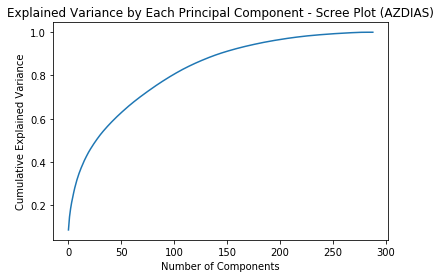

In [129]:
#Explained variance (AZDIAS)

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance by Each Principal Component - Scree Plot (AZDIAS)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()

### PCA on CUSTOMERS

Covariance Matrix

In [130]:
print('NumPy covariance matrix: \n%s' %np.cov(customers_scaled.T))

NumPy covariance matrix: 
[[ 1.00000745 -0.27971369 -0.19078248 ...  0.11959508  0.04996049
   0.01151731]
 [-0.27971369  1.00000745 -0.28157041 ...  0.1312266  -0.01788514
   0.0346101 ]
 [-0.19078248 -0.28157041  1.00000745 ... -0.03876423 -0.04564216
  -0.01805203]
 ...
 [ 0.11959508  0.1312266  -0.03876423 ...  1.00000745 -0.02228529
   0.05828411]
 [ 0.04996049 -0.01788514 -0.04564216 ... -0.02228529  1.00000745
  -0.37731709]
 [ 0.01151731  0.0346101  -0.01805203 ...  0.05828411 -0.37731709
   1.00000745]]


Performing eigendecomposition on the covariance matrix above

In [131]:
#Perform eigendecomposition on covariance matrix

cov_mat = np.cov(customers_scaled.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 1.46100352e-02 -1.76055973e-03  3.86971907e-02 ...  2.90512858e-03
   1.78701168e-03 -8.76405410e-05]
 [-1.32740958e-02 -5.06901093e-03  3.74311657e-02 ... -7.75105555e-04
  -1.45528221e-03 -3.08304496e-03]
 [-2.13233726e-02  1.25015398e-03 -2.29077413e-02 ...  1.39646921e-03
   1.16517524e-03 -2.14318372e-03]
 ...
 [-1.31558170e-02  1.19161809e-02  1.60895700e-01 ... -8.79702795e-02
   1.28777016e-02 -1.31899823e-03]
 [ 1.11183744e-01 -9.06529419e-02 -1.57271088e-02 ...  4.33813964e-04
  -5.35743140e-04 -1.59304528e-02]
 [-3.30661358e-02  6.17480117e-02  8.23676608e-02 ...  2.25161681e-03
   5.89005666e-04 -2.64748444e-03]]

Eigenvalues 
[ 2.16257866e+01  1.93180683e+01  8.15533339e+00  7.68208760e+00
  7.04962536e+00  6.42705265e+00  5.91608959e+00  5.17550517e+00
  4.87551479e+00  4.47685048e+00  4.29602755e+00  3.72318222e+00
  3.60661612e+00  3.53015614e+00  3.26341104e+00  3.19556046e+00
  2.94509750e+00  2.86281051e+00  2.79614215e+00  2.69157190e+00
  2.6447323

In [132]:
# Visually confirm that the list is correctly sorted by decreasing eigenvalues

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

print('Eigenvalues in descending order:')

for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
21.625786644575197
19.318068305517823
8.155333393550228
7.682087596590772
7.049625364736644
6.427052647635984
5.916089585106697
5.175505171005837
4.875514788419473
4.476850479474519
4.296027545157086
3.7231822229200007
3.6066161220352253
3.530156138505341
3.2634110351507295
3.19556046017375
2.9450975004661837
2.8628105105935244
2.796142153740747
2.6915719035734176
2.644732341896025
2.5576880809823987
2.4247787065100534
2.3098056127631432
2.231081703029744
2.163467190407079
2.095402882550707
1.980676523743016
1.9662106739067988
1.9527155860850614
1.8330446839949244
1.8164931064552798
1.7729995485550802
1.7291111361985225
1.7007403690576453
1.6796820241202592
1.6310752201087877
1.6001194761572322
1.575439542061807
1.5294361854792984
1.5122567088992735
1.4721655620059224
1.4552576830214
1.4358242354939572
1.4070418222345553
1.3731927458476045
1.3760655282136505
1.385062401753617
1.3862406919221881
1.344695071611482
1.325059736692721
1.307582503676682
1.304

Scree Plot

> To gain an informed view of how each principal component explains the variance within the data, we will create a scree plot.

> A scree plot displays the variance explained by each principal component.

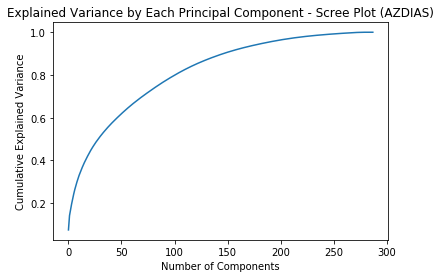

In [133]:
#Explained variance (CUSTOMERS)

pca = PCA()
customers_pca = pca.fit_transform(customers_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance by Each Principal Component - Scree Plot (AZDIAS)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()

We need to choose the number of components/features we want to keep after PCA.

We need to choose a number high enough so that the amount of variance in the dataset that is accounted by the selected components ('principal components') is still relatively high. This ywa, we don't lose too much information from the dataset because of the dimensionality reduction triggered by PCA.

### From the scree plots above, *150* seems to be an adequate number of components to reduce azdias and customers to.

In [166]:
def reduce_dimension(df, n=150):
    
    pca = PCA(n_components=n)
    
    reduced_df = pca.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df)
    
    print('The variance in the data explained by the principal components after employing PCA is equal to ' + str(pca.explained_variance_ratio_.sum())) 
    
    return reduced_df

In [167]:
reduced_azdias = reduce_dimension(azdias_scaled, n=150)

The variance in the data explained by the principal components after employing PCA is equal to 0.9093084707136746


In [168]:
reduced_customers = reduce_dimension(customers_scaled, n=150)

The variance in the data explained by the principal components after employing PCA is equal to 0.9037886613509647


Let's check the newly created `reduced_azdias` and `reduced_customers` dataframes.

In [169]:
reduced_azdias.shape

(737288, 150)

In [170]:
reduced_customers.shape

(134246, 150)

We can see that the number of columns in `reduced_customers` and `reduced_azdias` is 150, as expected after PCA with `n_components=150`.

### B. Clustering - k-Means Clustering

The Elbow Method: Finding the 'Optimal' Number of Clusters

In [171]:
def apply_kmeans(data, k):
    """
    Computes the average within-cluster distance for a specified number of clusters (n_clusters)
    
    INPUT:
    - data (array): the resultin array from PCA's fit_transform function
    - n_clusters (int): the number of clusters for applying k-means
    
    OUTPUT:
    None
    """


        
    kmeans = KMeans(n_clusters=k)
    
    model = kmeans.fit(data)
    
    return abs(model.score(data))

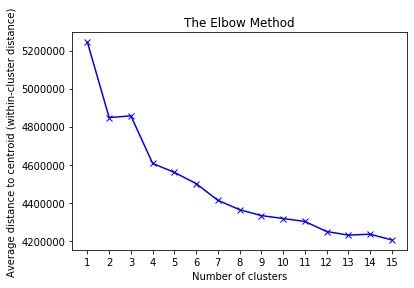

In [172]:
within_cluster_distances = []
clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for cluster_num in clusters:
    within_cluster_distances.append(apply_kmeans(reduced_azdias.sample(20000), cluster_num))
    

    
plt.plot(clusters, distances, linestyle='-', marker='x', color='blue')

plt.xticks(ticks=clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance to centroid (within-cluster distance)')
plt.title('The Elbow Method')

plt.show()

> The distance decreases as the number of clusters (k) we specify for k-means clustering increases.

In [173]:
within_cluster_distances

[5243844.998011864,
 4847917.406479839,
 4856796.559894204,
 4607103.86695875,
 4559633.292557795,
 4500932.221600813,
 4412967.304454098,
 4363790.311693423,
 4332580.388612804,
 4317290.321666483,
 4301923.734770228,
 4249003.601781184,
 4230069.648311325,
 4234920.614770736,
 4204823.099300647]

> From the graph above, using the Elbow Method, we come to the conclusion that **12** is the optimal number of clusters for k-means clustering on azdias.

In [174]:
n_clusters = 12

kmeans = KMeans(n_clusters=n_clusters)

For Azdias (General Population) 

In [175]:
# AZDIAS (the general population)

azdias_preds = kmeans.fit_predict(reduced_azdias)

In [176]:
azdias_preds

array([11,  0,  1, ...,  5,  3,  0], dtype=int32)

In [179]:
azdias_clustered = pd.DataFrame(azdias_preds, columns = ['Cluster'])

azdias_clustered.to_pickle('azdias_clustered.pkl')

For Customers (Customer Base)

In [177]:
# CUSTOMERS (the customer base)

customers_preds = kmeans.fit_predict(reduced_customers)

In [178]:
customers_preds

array([ 4,  8,  4, ...,  3, 10,  4], dtype=int32)

In [180]:
customers_clustered = pd.DataFrame(customers_preds, columns = ['Cluster'])

customers_clustered.to_pickle('customers_clustered.pkl')

### C. Comparing Clusters: General Population (azdias) vs Customer Base (customers) 

Now, we will look at and compare the distributions of the General Population data (AZDIAS) and Customer Base (CUSTOMERS), in each of the ??? clusters.

In [181]:
azdias_clusters = pd.Series(azdias_preds)

In [182]:
# predicted number of people in each general population cluster/segment
# pc = '(general) population cluster'

num_pc = azdias_clusters.value_counts().sort_index()

In [183]:
customers_clusters = pd.Series(customers_preds)

In [185]:
# predicted number of people in each customer cluster/segment
# cc = 'customer cluster'

num_cc = customers_clusters.value_counts().sort_index()

Summary Dataframe (for each cluster)

In [186]:
# Create dataframe from population and customer segments

summary_df = pd.concat([num_pc, num_cc], axis=1).reset_index()

summary_df.columns = ['Cluster #','General Population','Customer Base']

In [187]:
# adding percentage columns

summary_df['Perct of Total General Pop'] = ( summary_df['General Population'] / (summary_df['General Population'].sum()) * 100 ).round(2)

summary_df['Perct of Total Customer Base'] = ( summary_df['Customer Base'] / (summary_df['Customer Base'].sum()) * 100 ).round(2)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
                                                                                                                               

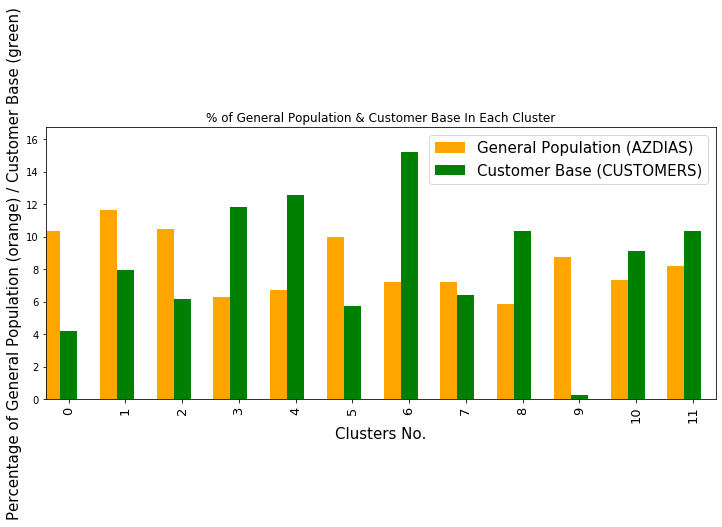

In [189]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)

ax = summary_df['Perct of Total General Pop'].plot(x=summary_df['Cluster #'], width=-0.3, align='edge', color='orange', kind='bar', position=0)
ax = summary_df['Perct of Total Customer Base'].plot(kind='bar', color='green', width = 0.3, align='edge', position=1)

ax.set_xlabel('Clusters No.', fontsize=15) 
ax.set_ylabel('Percentage of General Population (orange) / Customer Base (green)', fontsize=15)

ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('General Population (AZDIAS)', 'Customer Base (CUSTOMERS)'), fontsize=15)
plt.title(('% of General Population & Customer Base In Each Cluster'))

plt.show()

> Cluster 6 is the most overrepresented cluster in the customer data, while cluster 9 is the most underrepresented one in the customer data.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [125]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/dilay/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [126]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [127]:
mailout_train.shape

(42962, 367)

In [128]:
mailout_train_LNR = mailout_train['LNR']

# mailout_train.drop(labels=['LNR'], axis=1, inplace=True)

### Dealing with Class Imbalance

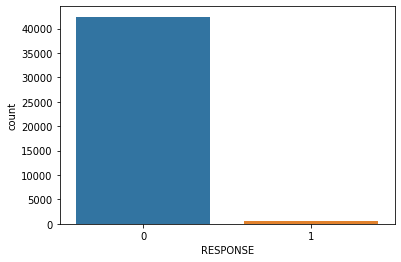

In [129]:
sns.countplot('RESPONSE', data=mailout_train)

> From the graph above, we can clearly see the class imbalance in the `mailout_train` dataset, with nearly all responses being 0 (i.e. not becoming a customer). 

In [130]:
Yes_Customer = mailout_train[mailout_train['RESPONSE']==1] 

No_Customer = mailout_train[mailout_train['RESPONSE']==0]

In [131]:
Yes_Customer_balanced = resample(Yes_Customer, replace=True, n_samples=42430, random_state=1) 

In [132]:
# Combine Yes_Customer_balanced and No_Customer data set 

mailout_train_balanced = pd.concat([No_Customer, Yes_Customer_balanced])

In [133]:
mailout_train_balanced['RESPONSE']

0        0
1        0
2        0
3        0
4        0
        ..
38176    1
2506     1
21762    1
9517     1
35633    1
Name: RESPONSE, Length: 84860, dtype: int64

### Cleaning & Preprocessing Training Data

In [134]:
# Define the labels (y) to be the response column, and drop it from mailout_train_balanced

y_label = mailout_train_balanced['RESPONSE']

mailout_train_balanced.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [135]:
# modified cleaning_function(): deleted 'dropping not described features'

def cleaning_function_2(df, attributes_info, not_described_features, columns_to_drop, nan_threshold=0.2):
    """
    Cleans and Preprocess a DataFrame df:
    - Drop features that are not described (described features summarised in attributes_info)
    - Convert missing and unknown values to NaN
    - Drop columns (so, features) with high percentage of NaN values (relative to nan_threshold)
    - Drop rows with high percentage of NaN values (relative to nan_threshold)
    - Re-encode categorical features and mixed features

    INPUT:
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - attributes_info (DataFrame): the DataFrame containing the features information/description (Attribute, Type, Unknown_Values)
    - not_described_features (list): list of features to be dropped because they are not described (not in attributes_info)
    - columns_to_drop (list): list of columns/features to be dropped because of a high percentage of NaN values (computed in prior steps)
    
    OUTPUT:
    - df (DataFrame): cleaned and preprocessed DataFrame
    """
    
    # drop features that are not described 
    df.drop(labels=not_described_features, axis=1, inplace=True)
    
    
    # for column in df.columns:
        # if df[column].dtype == np.int64:
            # df[column] = df[column].astype(np.float64)
    
        
    unknown_series = pd.Series(attributes_info['Unknown_Values'].values, index=attributes_info['Attribute'])
    # convert missing and unknown values to NaN values
    for column in df.columns:
        isin = ast.literal_eval(unknown_series[column])
        df[column] = df[column].mask(df[column].isin(isin), other=np.nan)
            
    
    # drop columns with percentage of NaN values higher than threshold (nan_threshold)   
    drop_columns = []
    for column in columns_to_drop:
        if column not in not_described_features:
            drop_columns.append(column)
            
        
    df.drop(labels=drop_columns, axis=1, inplace=True)
    
    # drop rows with percentage of NaN values higher than threshold (nan_threshold)   
    # missing_perct_row = df.isnull().mean(axis=1)
    # df = df[missing_perct_row < nan_threshold]
    
    
    # categorical features of df
    cat_feat_df = [] # categorical features (in attributes_info) that are also in df
    for cat_feat in categorical_features_attributes:
        if cat_feat in df.columns:
            cat_feat_df.append(cat_feat)
    
    # mixed features of df
    mixed_feat_df = [] # mixed features (in attributes_info) that are also in df
    for mixed_feat in mixed_features_attributes:
        if mixed_feat in df.columns:
            mixed_feat_df.append(mixed_feat)

            
    ### df categorical features re-encoding ###
    binary_num_attributes = []
    binary_non_num_attributes = []
    multi_level_attributes = []

    for attribute in cat_feat_df:
        dtype = df[attribute].dtype
        count = len(df[attribute].value_counts())

        # if multi-level categorical feature
        if count > 2:
            multi_level_attributes.append(attribute)
        else:
            if dtype == 'object':
                binary_non_num_attributes.append(attribute)
            else:
                binary_num_attributes.append(attribute)
    
    # re-encode binary string (non-numerical) feature into numerical values         
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    # re-encode multi-level categorical features
    list_columns_to_add = []

    for column in multi_level_attributes:
        
        # get rid of multi-level categorical columns with more than 10 levels
        if len(df[column].value_counts()) < 10:
            list_columns_to_add.append(pd.get_dummies(df[column], prefix=column))
    
    
    df.drop(multi_level_attributes, axis=1, inplace=True)

    list_columns_to_add.append(df) 

    df = pd.concat(list_columns_to_add, axis=1)
    
    
    ### df mixed features re-encoding ###
    
    # Re-encoding PRAEGENDE_JUGENDJAHRE feature
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # Dropping LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB features
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    # Re-encoding CAMEO_INTL_2015 feature
    df['WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    

    
    return df

In [136]:
# from Part 0 
# attributes_info = 

In [137]:
# from Part 0 azdias_not_described
not_described_features = ['UMFELD_ALT',
                          'ALTER_KIND2',
                          'CJT_TYP_5',
                          'CJT_TYP_6',
                          'AKT_DAT_KL',
                          'ALTER_KIND4',
                          'D19_LETZTER_KAUF_BRANCHE',
                          'STRUKTURTYP',
                          'D19_KONSUMTYP_MAX',
                          'CJT_TYP_2',
                          'VK_DHT4A',
                          'CJT_KATALOGNUTZER',
                          'RT_UEBERGROESSE',
                          'UMFELD_JUNG',
                          'LNR',
                          'EXTSEL992',
                          'FIRMENDICHTE',
                          'VHN',
                          'EINGEFUEGT_AM',
                          'GEMEINDETYP',
                          'CJT_TYP_4',
                          'CJT_TYP_3',
                          'RT_KEIN_ANREIZ',
                          'VHA',
                          'CJT_TYP_1',
                          'VK_ZG11',
                          'KOMBIALTER',
                          'VK_DISTANZ',
                          'VERDICHTUNGSRAUM',
                          'RT_SCHNAEPPCHEN',
                          'ALTER_KIND3',
                          'ALTER_KIND1'
                         ]

In [138]:
#columns_to_drop

missing_perct_column = mailout_train_balanced.isnull().mean(axis=0)

columns_to_drop = missing_perct_column[missing_perct_column > 0.2].index

In [139]:
missing_perct_column

LNR                     0.000000
AGER_TYP                0.000000
AKT_DAT_KL              0.159133
ALTER_HH                0.159133
ALTER_KIND1             0.956446
                          ...   
WOHNDAUER_2008          0.159133
WOHNLAGE                0.178388
ZABEOTYP                0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.000000
Length: 366, dtype: float64

In [140]:
columns_to_drop

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'HH_DELTA_FLAG', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3',
       'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX',
       'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL',
       'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2',
       'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_KRSAQUOT',
       'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
       'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL',
       'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ',
       'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1',
       'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MOTOR',
       'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3',
       'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6

In [141]:
# mailout_train_balanced.drop(labels=['AKT_DAT_KL'], axis=1, inplace=True)

In [142]:
train = cleaning_function_2(mailout_train_balanced, attributes_info, not_described_features, columns_to_drop, nan_threshold=0.2)

In [143]:
train.head()

,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,...,SEMIO_VERT,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_LEVEL,STATUS
0,0,1,0,0,1,0,0,0,0,0,...,3,0.0,0.0,2.0,9.0,3.0,2,4.0,3.0,4.0
1,1,0,0,0,1,0,0,0,0,1,...,4,0.0,0.0,1.0,9.0,7.0,2,3.0,3.0,2.0
2,1,0,0,0,0,0,1,0,0,0,...,7,0.0,0.0,1.0,9.0,2.0,1,4.0,1.0,4.0
3,0,1,0,0,1,0,0,0,0,0,...,2,0.0,0.0,2.0,9.0,1.0,2,4.0,1.0,4.0
4,0,1,0,0,0,0,0,0,1,0,...,7,0.0,0.0,1.0,9.0,3.0,1,3.0,4.0,1.0


In [144]:
train.shape

(84860, 304)

In [145]:
# Imputation 

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

train = pd.DataFrame(imputer.fit_transform(train))

In [146]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,2.0,9.0,3.0,2.0,4.0,3.0,4.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,1.0,9.0,7.0,2.0,3.0,3.0,2.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,7.0,0.0,0.0,1.0,9.0,2.0,1.0,4.0,1.0,4.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,9.0,1.0,2.0,4.0,1.0,4.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.0,0.0,0.0,1.0,9.0,3.0,1.0,3.0,4.0,1.0


In [147]:
train.shape

(84860, 304)

In [148]:
# Scaling 

scaler = StandardScaler()

train = pd.DataFrame(scaler.fit_transform(train))

In [149]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,-0.545612,1.520610,-0.251387,-0.461684,1.505401,-0.340877,-0.379683,-0.314341,-0.478781,-0.469908,...,-0.436067,-0.093728,-0.247522,1.198530,0.231422,-0.474137,0.852874,0.747642,0.081105,0.433009
1,1.832804,-0.657631,-0.251387,-0.461684,1.505401,-0.340877,-0.379683,-0.314341,-0.478781,2.128074,...,0.042079,-0.093728,-0.247522,-0.834355,0.231422,1.626729,0.852874,-0.212931,0.081105,-1.109707
2,1.832804,-0.657631,-0.251387,-0.461684,-0.664275,-0.340877,2.633776,-0.314341,-0.478781,-0.469908,...,1.476515,-0.093728,-0.247522,-0.834355,0.231422,-0.999353,-1.172505,0.747642,-1.441759,0.433009
3,-0.545612,1.520610,-0.251387,-0.461684,1.505401,-0.340877,-0.379683,-0.314341,-0.478781,-0.469908,...,-0.914212,-0.093728,-0.247522,1.198530,0.231422,-1.524570,0.852874,0.747642,-1.441759,0.433009
4,-0.545612,1.520610,-0.251387,-0.461684,-0.664275,-0.340877,-0.379683,-0.314341,2.088636,-0.469908,...,1.476515,-0.093728,-0.247522,-0.834355,0.231422,-0.474137,-1.172505,-0.212931,0.842537,-1.881064


In [150]:
train.shape

(84860, 304)

### A. Classification + Training with Various Supervised Machine Learning Algorithms

In [159]:
def classifier_training(classifier, param_grid, X=train, y=y_label):
    """
    Fit a classifier using GridSearchCV, compute ROC AUC metric
    
    INPUT:
    - classifier (classifier): classifier to fit 
    - param_grid (dict): parameters of the classifier used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    # using StratifiedKFold
    
    start = time.time()
    
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print('Time Taken:' + str(end-start))

    print(grid.best_score_)
    
    return grid.best_estimator_

**1) Benchmark Model: LogisticRegression**

In [153]:
logistic_reg = LogisticRegression(random_state=12)

In [154]:
print(classifier_training(logistic_reg, {}))

/Users/dilay/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/dilay/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

17.693526029586792
0.8079572604618249
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/dilay/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


> **Time taken: 17.69s / AUC of ROC curve = 0.81**

**2) RandomForestClassifier**

In [157]:
random_forest_clf = RandomForestClassifier(random_state=12)

In [158]:
print(classifier_training(random_forest_clf, {}))

157.43871474266052
0.9933765830443498
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)


> **Time taken: 157.44s / AUC of ROC curve = 0.99**

It looks like there might be an overfitting problem with our use of the RandomForestClassifier estimator, or another issue leading to an overfitting (on train dataset) problem, as the AUC of the ROC curve seems a bit 'off' (too high).

**3) GradientBoostingClassifier**

In [160]:
gbc = GradientBoostingClassifier(random_state=12)

In [161]:
print(classifier_training(gbc, {}))

Time Taken:395.87442922592163
0.8886032804776567
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=12, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


> **Time taken: 395.87s / AUC of ROC curve = 0.88**

**4) SupportVectorMachine (SVM)** 

#### I did not proceed with the SVM algorithm training, as it wasn't suited for this classification problems in terms of training duration (I came to this conclusion after subsequent research on the web and technical forums.

For example, see this Kaggle discussion on the matter:
https://www.kaggle.com/c/home-credit-default-risk/discussion/58515

In [162]:
svc = SVC(random_state=12)

In [163]:
print(classifier_training(svc, {}))

KeyboardInterrupt: 

> **Time taken: NA / AUC of ROC curve = NA.**

**5) AdaBoostClassifier**

In [165]:
adaboost = AdaBoostClassifier()

In [166]:
print(classifier_training(adaboost, {}))

Time Taken:99.71391987800598
0.7859658744471563
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


> **Time taken: 99s / AUC of ROC curve = 0.79**

### B. Model Selection and Tuning The 'Best' Model

**Given the AUC of ROC curve results above, and after reflection, we choose the GradientBoostingClassifier model to optimize (score: 0.89), using GridSearchCV and selected parameters from the result in 3).**

This model will then be used with the test dataset (Part 3) to make predictions.

In [171]:
gbc = GradientBoostingClassifier(random_state=12)

param_grid = {'loss': ['deviance'],
              'max_depth': [3],
              'learning_rate': [0.1],
              'n_estimators': [100],
              'random_state': [12]
             }


gbc_best_estimator = classifier_training(gbc, param_grid)

Time Taken:410.33228397369385
0.8886032804776567


In [172]:
gbc_best_estimator

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=12, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Comparison

In comparison to our Benchmark Model (Logistic Regressor), our chosen trained model, with the GradientBoostingClassifier algorithm performed better, with a higher AUC of the ROC curve:

0.889 > 0.807

For Part 3, we will thus use the GradientBoostingClassifier model with the following tuned hyperparameters:

> `learning_rate = 0.1`

> `n_estimators = 100`

> `max_depth = 3`

> `loss = 'deviance'`

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [185]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/dilay/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [186]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [187]:
mailout_test.shape

(42833, 366)

In [188]:
# Copying LNR column for Kaggle submission csv file
test_LNR = mailout_test['LNR']

mailout_test.drop(['LNR'], axis=1, inplace=True)

### Cleaning & Preprocessing Test Data

In [189]:
# modified cleaning_function(): no row-dropping, as here we want to predict for every row

def cleaning_function_test(df, attributes_info, not_described_features, columns_to_drop, nan_threshold=0.2):
    """
    Cleans and Preprocess a DataFrame df:
    - Drop features that are not described (described features summarised in attributes_info)
    - Convert missing and unknown values to NaN
    - Drop columns (so, features) with high percentage of NaN values (relative to nan_threshold)
    - Drop rows with high percentage of NaN values (relative to nan_threshold)
    - Re-encode categorical features and mixed features

    INPUT:
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - attributes_info (DataFrame): the DataFrame containing the features information/description (Attribute, Type, Unknown_Values)
    - not_described_features (list): list of features to be dropped because they are not described (not in attributes_info)
    - columns_to_drop (list): list of columns/features to be dropped because of a high percentage of NaN values (computed in prior steps)
    
    OUTPUT:
    - df (DataFrame): cleaned and preprocessed DataFrame
    """
    
    # drop features that are not described 
    df.drop(labels=not_described_features, axis=1, inplace=True)
    
    # for column in df.columns:
        # if df[column].dtype == np.int64:
            # df[column] = df[column].astype(np.float64)
            
    unknown_series = pd.Series(attributes_info['Unknown_Values'].values, index=attributes_info['Attribute'])
    # convert missing and unknown values to NaN values
    for column in df.columns:
            isin = ast.literal_eval(unknown_series[column])
            df[column] = df[column].mask(df[column].isin(isin), other=np.nan)
        
    
    # drop columns with percentage of NaN values higher than threshold (nan_threshold)   
    drop_columns = []
    for column in columns_to_drop:
        if column not in not_described_features:
            drop_columns.append(column)
            
        
    df.drop(labels=drop_columns, axis=1, inplace=True)
    
    
    # categorical features of df
    cat_feat_df = [] # categorical features (in attributes_info) that are also in df
    for cat_feat in categorical_features_attributes:
        if cat_feat in df.columns:
            cat_feat_df.append(cat_feat)
    
    # mixed features of df
    mixed_feat_df = [] # mixed features (in attributes_info) that are also in df
    for mixed_feat in mixed_features_attributes:
        if mixed_feat in df.columns:
            mixed_feat_df.append(mixed_feat)

            
    ### df categorical features re-encoding ###
    binary_num_attributes = []
    binary_non_num_attributes = []
    multi_level_attributes = []

    for attribute in cat_feat_df:
        dtype = df[attribute].dtype
        count = len(df[attribute].value_counts())

        # if multi-level categorical feature
        if count > 2:
            multi_level_attributes.append(attribute)
        else:
            if dtype == 'object':
                binary_non_num_attributes.append(attribute)
            else:
                binary_num_attributes.append(attribute)
    
    # re-encode binary string (non-numerical) feature into numerical values         
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    # re-encode multi-level categorical features
    list_columns_to_add = []

    for column in multi_level_attributes:
        
        # get rid of multi-level categorical columns with more than 10 levels
        if len(df[column].value_counts()) < 10:
            list_columns_to_add.append(pd.get_dummies(df[column], prefix=column))
    
    
    df.drop(multi_level_attributes, axis=1, inplace=True)

    list_columns_to_add.append(df) 

    df = pd.concat(list_columns_to_add, axis=1)
    
    
    ### df mixed features re-encoding ###
    
    # Re-encoding PRAEGENDE_JUGENDJAHRE feature
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))
    
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    # Dropping LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB features
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    # Re-encoding CAMEO_INTL_2015 feature
    df['WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    

    
    return df

In [190]:
not_described_features = ['UMFELD_ALT',
                          'ALTER_KIND2',
                          'CJT_TYP_5',
                          'CJT_TYP_6',
                          'AKT_DAT_KL',
                          'ALTER_KIND4',
                          'D19_LETZTER_KAUF_BRANCHE',
                          'STRUKTURTYP',
                          'D19_KONSUMTYP_MAX',
                          'CJT_TYP_2',
                          'VK_DHT4A',
                          'CJT_KATALOGNUTZER',
                          'RT_UEBERGROESSE',
                          'UMFELD_JUNG',
                          #'LNR',
                          'EXTSEL992',
                          'FIRMENDICHTE',
                          'VHN',
                          'EINGEFUEGT_AM',
                          'GEMEINDETYP',
                          'CJT_TYP_4',
                          'CJT_TYP_3',
                          'RT_KEIN_ANREIZ',
                          'VHA',
                          'CJT_TYP_1',
                          'VK_ZG11',
                          'KOMBIALTER',
                          'VK_DISTANZ',
                          'VERDICHTUNGSRAUM',
                          'RT_SCHNAEPPCHEN',
                          'ALTER_KIND3',
                          'ALTER_KIND1'
                         ]

In [191]:
test = cleaning_function_test(mailout_test, attributes_info, not_described_features, columns_to_drop, nan_threshold=0.2)

In [192]:
test.head()

,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,...,SEMIO_VERT,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_LEVEL,STATUS
0,0,1,0,0,0,0,0,1,0,0,...,7,0.0,0.0,1.0,9.0,3.0,1,4.0,1.0,3.0
1,0,0,0,1,0,0,0,0,0,0,...,6,0.0,0.0,1.0,9.0,5.0,1,4.0,3.0,1.0
2,0,1,0,0,1,0,0,0,0,0,...,3,0.0,1.0,1.0,9.0,4.0,2,4.0,4.0,1.0
3,0,0,0,0,0,0,1,0,0,0,...,2,0.0,0.0,2.0,9.0,2.0,2,4.0,1.0,3.0
4,1,0,0,0,0,0,0,0,1,1,...,3,0.0,0.0,1.0,9.0,7.0,2,4.0,3.0,1.0


In [193]:
test.shape

(42833, 304)

In [195]:
# Imputation 

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

test = pd.DataFrame(imputer.fit_transform(test))

In [196]:
# Scaling 

scaler = StandardScaler()

test = pd.DataFrame(scaler.fit_transform(test))

### Classification with Trained Model from Part 2

In [197]:
# Calculate prediction probabilities for the TEST set with previously trained GradientBoostingClassifier estimator

test_gbc_preds = gbc_best_estimator.predict_proba(test)

In [198]:
test_gbc_preds[:15]

array([[0.30052066, 0.69947934],
       [0.2751106 , 0.7248894 ],
       [0.79873286, 0.20126714],
       [0.92659509, 0.07340491],
       [0.71655568, 0.28344432],
       [0.92190775, 0.07809225],
       [0.84131076, 0.15868924],
       [0.45996852, 0.54003148],
       [0.56097224, 0.43902776],
       [0.7875735 , 0.2124265 ],
       [0.88593846, 0.11406154],
       [0.28457559, 0.71542441],
       [0.75589434, 0.24410566],
       [0.84198771, 0.15801229],
       [0.27490217, 0.72509783]])

### CSV File for Kaggle Submission

Columns: the LNR id column + prediction of response column

In [199]:
kaggle = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':test_gbc_preds[:, 1]})

kaggle.to_csv('kaggle.csv', index=False)

In [200]:
kaggle.head()

,LNR,RESPONSE
0,1754,0.699479
1,1770,0.724889
2,1465,0.201267
3,1470,0.073405
4,1478,0.283444


In [204]:
len(kaggle[kaggle['RESPONSE']>0.5])

8883

Out of 42,833 individuals (rows in the test dataset), 8,883 individuals seems likely to become a customer (i.e. their individual prediction>0.5), which approximately equals to 20% of the total test individuals (42,833).